## 1 加载数据

In [12]:
import numpy as np
import pandas as pd

import requests
from collections import Counter
import json
from copy import deepcopy
import time
from tqdm import tqdm

from pyecharts import options as opts
from pyecharts.charts import BMap, Line
from pyecharts.globals import GeoType

In [4]:
#     "mobile": "./data/mobile.csv",

structure = {
    "clean_mobile": "./data/clean_mobile.csv",
    "station": "./data/station.csv",
    "station_with_poi_feature" : "./data/station_POI_total.csv", 
    "station_with_geo_feature" : "./data/station_GEO.csv",
    "station_with_user_feature" : "./data/station_USER.csv"
}

In [134]:
## 百度地图 AK
chromeKey = 'iyIWDHxKY0gr31gMNsCvyANoeOvjQMrE'
appKey = 'h6L37WQDKG6B1MM8lc3STrjUezh3PQb2'

### 1.1 数据基本分析  
首先，我们先画出所有基站在地图上的分布

#### 基站布局散点图

In [67]:
mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
            .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=10, is_roam=False,
                        map_style=json.load(open("./mapstyle/green.json", "r")))

for i in range(station_data.shape[0]): # 添加所有基站的坐标
    mapWorker.add_coordinate(name=station_data.iloc[i, 0], longitude=station_data.iloc[i, 1], latitude=station_data.iloc[i, 2])

c = mapWorker.add(
        series_name="Station", 
        data_pair=[(st, 100) for st in station_data['station_id'].to_list()],
        # type_=GeoType.EFFECT_SCATTER,
        symbol_size=4,
        blur_size=0,
        point_size=1,
        label_opts=opts.LabelOpts(is_show=False),
        effect_opts=opts.EffectOpts(is_show=False),
        itemstyle_opts=opts.ItemStyleOpts(color='rgba(218, 112, 214, 0.5)'), # 紫罗兰色，透明度0.5
    ) \
    .add_control_panel(
        navigation_control_opts=opts.BMapNavigationControlOpts(),
        overview_map_opts=opts.BMapOverviewMapControlOpts(),
        scale_control_opts=opts.BMapScaleControlOpts(),
    ) \
    .set_global_opts(
            title_opts=opts.TitleOpts(title="基站布局散点图", pos_left='right'), visualmap_opts=None, #opts.VisualMapOpts()
    ) \
    .render("./outcomes/web/station_distribution.html")

#### 基站访问频次热力图

In [133]:
station_frequency = Counter(mobile_data['station_id'].to_list())
max_freq = max(station_frequency.values())

In [134]:
station_frequency = [(st, float(val)*20/max_freq) for st, val in station_frequency.items()]

In [138]:
mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
            .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=10, is_roam=True,
                        map_style=json.load(open("./mapstyle/green.json", "r"))
            )

for i in range(station_data.shape[0]): # 添加所有基站的坐标
    mapWorker.add_coordinate(name=station_data.iloc[i, 0], longitude=station_data.iloc[i, 1], latitude=station_data.iloc[i, 2])

c = mapWorker.add(
        series_name="Station", 
        data_pair=station_frequency,
        type_=GeoType.HEATMAP,
        label_opts=opts.LabelOpts(is_show=False),
    ) \
    .add_control_panel(
        navigation_control_opts=opts.BMapNavigationControlOpts(),
        overview_map_opts=opts.BMapOverviewMapControlOpts(),
        scale_control_opts=opts.BMapScaleControlOpts(),
    ) \
    .set_global_opts(
            title_opts=opts.TitleOpts(title="基站访问人数热力图", pos_left='right'), visualmap_opts=opts.VisualMapOpts()
    ) \
    .render("./outcomes/web/station_frequency.html")

### 1.2 数据补充

利用百度地图API获取基站附近该兴趣的机构数量，以此来作为基站的特征。  
我挑选了一些具有代表性的关键字，包括了以下12个方面：  

In [4]:
key_words = ["美食","酒店","生活服务$汽车服务","旅游景点$自然地物","休闲娱乐$购物$运动健身$文化传媒","教育培训","医疗","交通设施","金融","房地产","公司企业","政府机构"][:6]

In [132]:
# data = pd.DataFrame({poi.strip():[0]*len(station_data) for poi in key_words})
# df = pd.concat([station_data, data],axis=1)

# df.to_csv("./data/station_POI.csv", index=False)

然后，使用request库来对基站附近POI数目进行统计。

In [5]:
query_str = "http://api.map.baidu.com/place/v2/search"

payload={
    "query": "银行",
    "location": "39.915,116.404",
    "radius": 500,
    "output": "json",
    "page_num": 0,
    "page_size": 20,
    "ak": chromeKey,
}

In [6]:
poi_df = pd.read_csv(structure["station_with_poi_feature"], sep=",", header=0)
N = poi_df.shape[0]
tmp_payload = deepcopy(payload)
print(tmp_payload)

for i in range(N):
    lng, lat = poi_df.iloc[i, 1:3]
    tmp_payload["location"] = "{},{}".format(lat, lng)
    
    for keyWord in key_words[3:]:
        tmp_payload["query"] = keyWord
        # push request
        try:
            r = requests.get(query_str, params=tmp_payload)
        except Exception as e:
            print(e)
            print("Query failure at Pair: [{}, {}]".format(i, keyWord))
            print("Time sleeping.... and Retry")
            time.sleep(60)
            r = requests.get(query_str, params=tmp_payload)
        # store request results
        try:
            if r.json()["status"] == 0:
                poi_df.loc[i, keyWord] = r.json()["total"]
            else:
                poi_df.loc[i, keyWord] = 0
        except Exception as e:
            print(e)
            print("Query failure, Pair: [{}, {}], Status: {}, Message: {}".format(i, keyWord, r.json()["status"], r.json()["message"]))
            print("Adding 0 to the list....")
            poi_df.loc[i, keyWord] = 0
    
    if i%100 == 0 or i == N-1:
        poi_df.to_csv(structure["station_with_poi_feature"], index=False)


{'query': '银行', 'location': '39.915,116.404', 'radius': 500, 'output': 'json', 'page_num': 0, 'page_size': 20, 'ak': 'iyIWDHxKY0gr31gMNsCvyANoeOvjQMrE'}


In [8]:
# poi_df = pd.read_csv(structure["station_with_poi_feature"], sep=",", header=0)
# adder_df = pd.read_csv("./data/station_POI_lrp.csv",  sep=",", header=0)
# adder_df = adder_df.drop(columns=["lng", "lat"])

# poi_df = pd.merge(left=poi_df, right=adder_df, on="station_id")

# poi_df.shape
# poi_df.to_csv("./data/station_POI_total.csv", index=False)

(6160, 15)

接下来，根据各基站的经纬度，我们来获取基站所属的行政区信息。已知上海有16个区。

In [5]:
districts = ["黄浦区","徐汇区","长宁区","静安区","普陀区 ","虹口区","杨浦区","浦东新区",
             "闵行区","宝山区","嘉定区","金山区","松江区","青浦区","奉贤区","崇明区"]

In [6]:
geo_info = ["formatted_address", "district", "street", "adcode", "business"]
data = pd.DataFrame({geo_level.strip():[""]*len(station_data) for geo_level in geo_info})
df = pd.concat([station_data, data],axis=1)

df.to_csv("./data/station_GEO.csv", index=False)

In [7]:
reverse_geocoding_str = "http://api.map.baidu.com/reverse_geocoding/v3/?"

new_payload={
    "location": "lat, lng",
    "output": "json",
    "ak": chromeKey,
    "language_auto": 1,
    "language": "zh-CN", 
}

In [12]:
geo_df = pd.read_csv(structure["station_with_geo_feature"], sep=",", header=0)
N = geo_df.shape[0]
tmp_payload = deepcopy(new_payload)
print(tmp_payload)

for i in tqdm(range(N)):
    lng, lat = geo_df.iloc[i, 1:3]
    tmp_payload["location"] = "{},{}".format(lat, lng)
    try:
        r = requests.get(reverse_geocoding_str, params=tmp_payload)
    except Exception as e:
        print(e)
        print("Request Failure at {}".format(i))
        geo_df.to_csv(structure["station_with_geo_feature"], index=False)
        time.sleep(30)
        print("Retry ..... ")
        r = requests.get(reverse_geocoding_str, params=tmp_payload)

    try:
        if r.json()["status"] == 0:
            result = r.json()["result"]
            geo_df.loc[i, "formatted_address"] = result['formatted_address']
            geo_df.loc[i, "district"] = result['addressComponent']['district']
            geo_df.loc[i, "street"] = result['addressComponent']['street']
            geo_df.loc[i, "adcode"] = result['addressComponent']['adcode']
            geo_df.loc[i, "business"] = result['business']
        else:
            print("Bad Status at {}".format(i))
            continue
    except Exception as e:
        print(e)
        print("Storing Failure at {}".format(i))
        geo_df.to_csv(structure["station_with_geo_feature"], index=False)
        continue
    
    if i % 200 == 0:
        geo_df.to_csv(structure["station_with_geo_feature"], index=False)

geo_df.to_csv(structure["station_with_geo_feature"], index=False)

此外，我们还获取了上海2017年各区GDP数据（单位：亿元）、上海各区常住人口数目（单位：万人），上海各区面积数据（单位：平方千米）。

In [8]:
districtsINFO = {'浦东新区': {'GDP': 9651.39, '人口': 504.443, '面积': 1210, '别名': 'Pu Dong'},
 '闵行区': {'GDP': 2237.29, '人口': 242.9372, '面积': 372, '别名': 'Min Hang'},
 '嘉定区': {'GDP': 2151.7, '人口': 147.1231, '面积': 464, '别名': 'Jia Ding'},
 '黄浦区': {'GDP': 2104.44, '人口': 85.2476, '面积': 20, '别名': 'Huang Pu'},
 '静安区': {'GDP': 1703.68, '人口': 24.6788, '面积': 37, '别名': 'Jing An'},
 '杨浦区': {'GDP': 1703.19, '人口': 131.3222, '面积': 61, '别名': 'Yang Pu'},
 '徐汇区': {'GDP': 1573.94, '人口': 108.513, '面积': 55, '别名': 'Xu Hui'},
 '长宁区': {'GDP': 1317.52, '人口': 69.0571, '面积': 38, '别名': 'Chang Ning'},
 '宝山区': {'GDP': 147.366, '人口': 190.4886, '面积': 294, '别名': 'Bao Shan'},
 '松江区': {'GDP': 1120.97, '人口': 158.2398, '面积': 605, '别名': 'Song Jiang'},
 '青浦区': {'GDP': 1009.23, '人口': 108.1022, '面积': 676, '别名': 'Qing Pu'},
 '金山区': {'GDP': 978.32, '人口': 73.241, '面积': 611, '别名': 'Jin Shang'},
 '普陀区': {'GDP': 933.46, '人口': 128.8881, '面积': 56, '别名': 'Pu Tuo'},
 '虹口区': {'GDP': 780.49, '人口': 85.2476, '面积': 23, '别名': 'Hong Kou'},
 '奉贤区': {'GDP': 779.33, '人口': 108.3463, '面积': 687, '别名': 'Feng Xian'},
 '崇明区': {'GDP': 332.84, '人口': 70.3722, '面积': 1411, '别名': 'Chong Ming'},}

In [35]:
# df = pd.DataFrame(districtsINFO).T

In [150]:
# import pickle

# with open("./data/districtsINFO.pkl", "wb") as f:
#     pickle.dump(districtsINFO, f)
# 
# districtsINFO == pickle.load(open("./data/districtsINFO.pkl", "rb"))

## 2 描述性分析

### 2.1 各基站附近 POI 可视化

In [9]:
station_poi_data = pd.read_csv(structure["station_with_poi_feature"], sep=",", header=0)

In [34]:
""" SCATTER MAP """

def draw_scatterMap(data=None, second_key=None, color=(255,106,106), a=0.5, 
                    first_key='station_id', title=None, outName=None, outPath="./outcomes/web"):
    
    assert data is not None and second_key is not None
    if title is None: title = second_key
    if outName is None: outName = second_key
    
    mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
                .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=11, is_roam=False,
                            map_style=json.load(open("./mapstyle/green.json", "r")))

    for i in range(data.shape[0]): # 添加所有基站的坐标
        mapWorker.add_coordinate(name=data.iloc[i, 0], 
                                longitude=data.iloc[i, 1], 
                                latitude=data.iloc[i, 2])

    r,g,b = color
    c = mapWorker.add(
            series_name="Station", 
            data_pair=[tuple(itempair) for itempair in np.array(data[[first_key, second_key]]).tolist()],
            symbol_size=4,
            blur_size=0,
            point_size=1,
            label_opts=opts.LabelOpts(is_show=False),
            effect_opts=opts.EffectOpts(is_show=False),
            itemstyle_opts=opts.ItemStyleOpts(color='rgba({}, {}, {}, {})'.format(r, g, b, a)),
        ) \
        .add_control_panel(
            navigation_control_opts=opts.BMapNavigationControlOpts(),
            overview_map_opts=opts.BMapOverviewMapControlOpts(),
            scale_control_opts=opts.BMapScaleControlOpts(),
        ) \
        .set_global_opts(
                title_opts=opts.TitleOpts(title="{}".format(title), pos_left='right'), visualmap_opts=None, #opts.VisualMapOpts()
        ) \
        .render("{}/scatter_{}.html".format(outPath, outName))
    
    print("Saved html in [{}/scatter_{}.html]".format(outPath, outName))

In [ ]:
draw_scatterMap(data=station_poi_data, second_key="美食", color=(135, 206, 250), a=0.6) # 天空蓝
draw_scatterMap(data=station_poi_data, second_key="酒店", color=(238, 130, 238), a=0.6) # 浅紫色
draw_scatterMap(data=station_poi_data, second_key="生活服务$汽车服务", color=(238, 59, 59), a=0.6, title="生活服务") # Brown1

In [58]:
""" HEAT MAP """

def draw_heatMap(data=None, second_key=None, range_color=None,
                    first_key='station_id', title=None, outName=None, outPath="./outcomes/web"):
    
    assert data is not None and second_key is not None and range_color is not None
    if title is None: title = second_key
    if outName is None: outName = second_key
    
    mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
                .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=11, is_roam=False,
                            map_style=json.load(open("./mapstyle/green.json", "r")))

    for i in range(data.shape[0]): # 添加所有基站的坐标
        mapWorker.add_coordinate(name=data.iloc[i, 0], 
                                longitude=data.iloc[i, 1], 
                                latitude=data.iloc[i, 2])

    cur_array = np.array(data[[first_key, second_key]])

    c = mapWorker.add(
            series_name="Station", 
            data_pair=[tuple(itempair) for itempair in cur_array.tolist()],
            type_=GeoType.HEATMAP,
            # symbol_size=4,
            # blur_size=0,
            # point_size=1,
            label_opts=opts.LabelOpts(is_show=False),
        ) \
        .add_control_panel(
            navigation_control_opts=opts.BMapNavigationControlOpts(),
            overview_map_opts=opts.BMapOverviewMapControlOpts(),
            scale_control_opts=opts.BMapScaleControlOpts(),
        ) \
        .set_global_opts(
                title_opts=opts.TitleOpts(title="{}".format(title), pos_left='right'), 
                visualmap_opts=opts.VisualMapOpts(
                    range_color=range_color,
                    min_=np.min(cur_array[:, 1]),
                    max_= max(1500, np.max(cur_array[:, 1])*13),
                    orient="horizontal", pos_right= "5%",
                ),
        ) \
        .render("{}/heat_{}.html".format(outPath, outName))
    
    print("Saved html in [{}/heat_{}.html]".format(outPath, outName))

In [69]:
blue_family_1 = ['0, 245, 255', '0, 229, 238', '0, 197, 205', '0, 134, 139', '0, 0, 128'] # 美食
blue_family_2 = ['99, 184, 255', '92, 172, 238', '79, 148, 205', '30, 144, 255', '16, 78, 139'] # 医疗
orange_family_1  = ['238, 221, 130', '255, 255, 0', '255, 215, 0', '255, 193, 37', '255, 127, 36'] # 教育培训
red_family_1 = ['255, 193, 193', '238, 180, 180', '205, 155, 155', '255, 106, 106', '139, 26, 26'] # 交通设置
purple_family_1 = ['255, 0, 255', '238, 130, 238', '221, 160, 221', '218, 112, 214', '153, 50, 204'] # 公司企业
green_family_1 = ['127, 255, 212', '152, 251, 152', '102, 205, 170', '50, 205, 50', '34, 139, 34'] # 休闲娱乐$购物$运动健身$文化传媒

In [70]:
color=blue_family_2

draw_heatMap(data=station_poi_data, second_key="医疗", 
             range_color=['rgba({}, {})'.format(color[0], 0.6 + 0.04*i) for i in range(10)]+ \
                         ['rgba({}, {})'.format(color[1], 0.6 + 0.04*i) for i in range(10)]+ \
                         ['rgba({}, {})'.format(color[2], 0.5 + 0.05*i) for i in range(10)] + \
                         ['rgba({}, {})'.format(color[3], 0.4 + 0.05*i) for i in range(12)] + \
                         ['rgba({}, {})'.format(color[4], 0.50 + 0.08*i) for i in range(2)]
            )

Saved html in [./outcomes/web/heat_医疗.html]


### 2.2 基站所覆盖人口数据可视化

我们首先统计了每一个基站所能覆盖的人口数量和总的记录频次。

In [6]:
def func1():
    data = pd.DataFrame({key.strip():[0]*len(station_data) for key in ["用户数", "记录数", "人均记录数"]})
    df = pd.concat([station_data, data],axis=1)

    id_2_rowidx = dict([(df.iloc[i, 0], i) for i in range(df.shape[0])])
    not_found = set()

    for i in range(1381756, mobile_data.shape[0]):
        station_id, count = mobile_data.iloc[i, 1:3]
        if station_id in id_2_rowidx:            
            df.loc[id_2_rowidx[station_id], "用户数"] += 1
            df.loc[id_2_rowidx[station_id], "记录数"] += count
        else:
            not_found.add(station_id)

    for i in range(df.shape[0]):
        df.loc[i, "人均记录数"] = df.loc[i, "记录数"] / float(df.loc[i, "用户数"])

    # df.to_csv(structure["station_with_user_feature"], index=False)

In [14]:
station_user_data = pd.read_csv(structure["station_with_user_feature"], sep=",", header=0)

print(station_user_data.shape)
station_user_data.head()

(6160, 8)


,station_id,lng,lat,用户数,记录数,人均记录数,district,_district
0,C0001,121.3992,31.3393,1399,18368,13.129378,宝山区,Bao Shan
1,C0002,121.3782,31.3233,0,0,NaN,宝山区,Bao Shan
2,C0003,121.4052,31.3263,388,1589,4.095361,宝山区,Bao Shan
3,C0004,121.3942,31.3083,376,4231,11.252660,宝山区,Bao Shan
4,C0005,121.4212,31.3053,664,6516,9.813253,宝山区,Bao Shan


In [10]:
# df = pd.DataFrame({"_district":["null"]*len(station_user_data)})
# station_user_data = pd.concat([station_user_data, df], axis=1)

# for i in range(len(station_user_data)):
#     st = station_user_data.loc[i, "district"]
#     if st in districtsINFO:
#         station_user_data.loc[i, "_district"] = districtsINFO[st]['别名']
# station_user_data.to_csv(structure["station_with_user_feature"], index=False)

然后，我们计算了上海16个区内的基站数目、基站总记录人数、基站总记录频次、

In [26]:
# station_user_data = pd.read_csv("./data/station_USER.csv", sep=",", header=0)
# grouped = station_user_data.groupby(["district"])

# districtsDF = pd.concat([grouped["station_id"].count(), grouped["用户数"].sum(), grouped["记录数"].sum()], axis=1)
# districtsDF = pd.merge(left=districtsDF, right=df, how="right", left_index=True, right_index=True)
# districtsDF.to_csv("./data/districtsINFO.csv")

In [33]:
districtsDF = pd.read_csv("./data/districtsINFO.csv", sep=",", header=0)

In [31]:
m = (
    Line(init_opts=opts.InitOpts(width="1200px", height="600px"))
    .add_xaxis(xaxis_data=districtsDF["行政区"].tolist())
    .add_yaxis(
        series_name="基站数目",
        y_axis=districtsDF["基站数"].tolist(),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值"),
            ]
        ),
    )
    .add_yaxis(
        series_name="log2 用户数",
        y_axis=(np.log2(np.array(districtsDF["用户数"].astype(np.float32))) * 100).astype(np.int32).tolist(),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值"),
            ]
        ),
    )
    .add_yaxis(
        series_name="GDP",
        y_axis=["4000+"] + np.array(districtsDF.loc[1:, "GDP"]).astype(np.int32).tolist(),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值"),
            ]
        ),
    )
    .add_yaxis(
        series_name="人口",
        y_axis=np.array(districtsDF["人口"]).astype(np.int32).tolist(),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值"),
            ]
        ),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="上海市基站数据分区汇总", subtitle="made by 16307110435"),
        tooltip_opts=opts.TooltipOpts(trigger="axis"),
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
        yaxis_opts=opts.AxisOpts()
    )
    .render("./outcomes/web/上海市基站数据分区汇总.html")
)

### 2.3 用户行为分析


首先，我们定义用户的兴趣因子。已知用户i被基站A记录的次数为 $q_{iA}$。  
给定用户 $i$ ，给定用户去过的所有基站 $S_{i}$ ，则基站 $A$ 被用户访问的概率为：
$$ m_{iA} = \frac{q_{iA}}{\sum_{B \in S_i}{q_{iB}}} $$
则，可以定义用户 $i$ 对兴趣地点(POI) $X$ 的**兴趣因子**为：
$$
L_{iX} = \sum_{A \in S_i}{ m_{iA} \cdot n_{AX} }
$$
其中 $n_{AX}$ 表示基站 $A$ 附近兴趣地点(POI) $X$ 的个数。  
  
我们选取12个POI中得分最高的3个作为用户的兴趣所在。由此可以得到以下词云图。

具体数据处理细节：由于我们的User数目太多，因此我使用了spark来进行大规模数据的运算。  
1.  首先，我对基站数据进行了清洗。在给定的6160个基站中，删除了位置不在上海的基站，得到6095个基站。  
2.  然后，我对用户数据进行了清洗。由于用户访问过的基站不完全在station_data中，因此删除了在给定基站之外的用户访问记录。  
3.  最后，根据用户对基站的访问数据，删除了没有被用户访问过的基站。  
最终我对 4069287 条用户访问基站数据进行了上述数据处理，并最终得到了 77937 个用户的兴趣因子。

#### 2.3.1 词云图

In [1]:
dataRDD = spark.createDataFrame(interest_index).rdd
def top3_poi_mapper(row, reference):
    user_id = row['user_id']
    poi_score = [(i, row[key]) for i, key in enumerate(reference)]
    top_3_poi = [reference[idx] for idx, s in sorted(poi_score, key=lambda x: x[1], reverse=True)[:3]]

    return (user_id, top_3_poi)

result = dataRDD.map(lambda x: top3_poi_mapper(x, columns)) \
                .collect()
assert len(result) == len(interest_index)

In [2]:
top_1_poi, top_2_poi, top_3_poi = [], [], []

for user_id, interests in result:
    top_1_poi.append(interests[0])
    top_2_poi.append(interests[1])
    top_3_poi.append(interests[2])

from collections import Counter

top_1_counter = Counter(top_1_poi)
top_2_counter = Counter(top_2_poi)
top_3_counter = Counter(top_3_poi)

total_counter = Counter(top_1_poi + top_2_poi + top_3_poi)

from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def makeImage(word_dict, title="tmp"):
    city_mask = np.array(Image.open("./figures/Shanghai.jpeg"))
    wc = WordCloud(background_color="white", font_path="./SourceHanSans-Regular.ttc", 
                   width=1000, height=1000)
    wc.fit_words(word_dict)
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("./figures/{}.png".format(title))

In [3]:
makeImage(top_3_counter, title="Top_3_POI")

#### 2.2 典型用户分析
从所有这些用户中，我们选取了一些具有特点的用户，可视化了用户的轨迹，将用户频繁访问地点的poi向量与用户的兴趣因子进行比较，阐述了我们所定义指标的合理性。

以下用户为随机抽取结果，用户所属类别由用户interest index最大的类别决定。

In [4]:
cases = {
    '美食': {23682, 26691, 67396, 42086, 67336, 48910, 71919, 6640, 11829, 43222},
    '酒店': {10112, 28832, 37289, 33900, 54674, 58397},
    '生活服务$汽车服务': {70752, 47170, 27618, 21094, 5126, 25067, 34956, 21421, 75317},
    '旅游景点$自然地物': {63393, 53730, 42339, 40068, 71393, 33958, 66568, 63349, 27161},
    '休闲娱乐$购物$运动健身$文化传媒': {29664, 19171, 56869, 18662, 53255, 24363, 1809, 73430, 44441, 5086},
    '教育培训': {64802, 26722, 45387, 71855, 21167, 13906, 28629, 38198, 54205},
    '医疗': {7523, 32700},
    '交通设施': {48515, 13734, 13927, 1256, 17319, 54539, 35083, 66292, 40443, 8221},
    '金融': set(),
    '房地产': {55234, 69572, 62149, 6376, 45388, 63373, 55796, 38167, 44220, 8351},
    '公司企业': {35936, 16224, 6050, 42503, 38092, 77613, 70062, 51188, 24888, 64025},
    '政府机构': {898, 46373, 70085, 71495, 69833, 47146, 39922, 36148, 13846, 71835},
}

In [5]:
clean_mobile = pd.read_csv("./data/clean_mobile.csv", sep=',', header=0)

station_data = pd.read_csv("./data/station.csv", sep='\t', header=0)

In [10]:
key = "房地产"

colors = [
    (151, 255, 255), # DarkSlateGray1
    (118, 238, 198), # Aquamarine2
    (0, 255, 127), # SpringGreen1
    (132, 112, 255), # LightSlateBlue
    (255, 255, 0), # Yellow1
    (255, 193, 37), # Goldenrod1	
    (255, 193, 193), # RosyBrown1
    (255, 106, 106), # IndianRed1
    (238, 130, 238), # Violet
    (160, 32, 240), # purple
]

title = "2.2 用户分析 - {}".format(key)

In [47]:
station_data.shape

(6160, 3)

In [11]:
mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
                .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=11, is_roam=False,
                            map_style=json.load(open("./mapstyle/green.json", "r")))

for i in range(station_data.shape[0]): # 添加所有基站的坐标
    mapWorker.add_coordinate(name=station_data.iloc[i, 0], 
                            longitude=station_data.iloc[i, 1], 
                            latitude=station_data.iloc[i, 2])


for i, user_id in enumerate(cases[key]):
    r, g, b = colors[i]
    data = clean_mobile.loc[clean_mobile['user_id'] == user_id].reset_index(drop=True)
    data_pair = [(data.loc[j, 'station_id'], str(data.loc[j, 'count'])) for j in range(len(data))]
    mapWorker = mapWorker.add(
        series_name=str(user_id), 
        data_pair=data_pair,
        type_=GeoType.EFFECT_SCATTER,
        # symbol_size=4,
        # blur_size=0,
        # point_size=1,
        label_opts=opts.LabelOpts(is_show=False),
        effect_opts=opts.EffectOpts(is_show=True),
        itemstyle_opts=opts.ItemStyleOpts(color='rgba({}, {}, {}, {})'.format(r, g, b, 0.5)),
    )
    
c = mapWorker.add_control_panel(
        navigation_control_opts=opts.BMapNavigationControlOpts(),
        overview_map_opts=opts.BMapOverviewMapControlOpts(),
        scale_control_opts=opts.BMapScaleControlOpts(),
    ) \
    .set_global_opts(
        title_opts=opts.TitleOpts(title="{}".format(title), pos_left='right'), visualmap_opts=None, #opts.VisualMapOpts()
    ) \
    .render("{}/2.2_user_{}.html".format("./outcomes/web", key))
    
print("Saved html in [{}/2.2_user_{}.html]".format("./outcomes/web", key))

Saved html in [./outcomes/web/2.2_user_房地产.html]


In [12]:
list(t[['station_id', 'count']])

['station_id', 'count']

## 3 建模分析

### 3.1 基于区域熵的地点研究
已知用户i被基站A记录的次数为 $q_{iA}$，去过地点A的所有用户集合为 $\Phi_A$。定义用户i被基站A记录的概率为 $p_{iA}$
$$ p_{iA} = \frac{q_{iA}}{ \sum_{j \in \Phi_A}{q_jA} } $$
则地点A的熵被定义为：
$$ E_A = - \sum_{i \in \Phi_A} p_{iA} \log{p_{iA}} $$

In [3]:
import os
import sys
import pandas as pd
import numpy as np
os.environ['JAVA_HOME'] = '/home/zjw/jdk1.8.0_251'

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("zjw_advFin")\
        .config('spark.executor.memory', '12g') \
        .config('spark.driver.memory', '12g') \
        .config('spark.driver.maxResultSize', '2048MB') \
        .config('spark.executor.cores', '8') \
        .getOrCreate()

In [4]:
dataDF = spark.read.csv("file://" + "/home/zjw/ZJW_SPACE/spark/remote/mobile_data.csv", header=True)
dataDF = dataDF.drop('frac')
dataRDD = dataDF.rdd

In [5]:
def prob_mapper(x):
    station_id, info = x
    info = np.array(info).astype(np.float64)
    info = info / np.sum(info)
    entropy = (-1) * np.sum(info * np.log(info))

    return (station_id, entropy)

result1 = dataRDD.map(lambda x: (x['station_id'], [float(x['count'])])) \
                   .reduceByKey(lambda x, y: x+y) \
                   .map(prob_mapper) \
                   .collect()

In [6]:
result2 = dataRDD.map(lambda x: (x['station_id'], [float(x['count'])])) \
         .reduceByKey(lambda x, y: [x[0]+y[0]]) \
         .collect()

In [7]:
len(result2)

5236


In [8]:
stationDict = dict(result2)

for st, entropy in result1:
    stationDict[st].append(entropy)

In [9]:
import matplotlib.pyplot as plt

data_pairs = np.array(list(stationDict.values()))

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = axes[0]
ax.scatter(data_pairs[:, 0], data_pairs[:, 1], alpha=0.5, edgecolors= 'white', s=10, label="scatter")
ax.plot(np.exp(np.array(x))[20:], y[20:], color="blue", label="fitted values")
ax.set_title("Entropy", size=15)
ax.set_xscale("log")
ax.grid()
ax.set_xlabel("number of visits", size=13)
ax.set_ylabel("entropy", size=13)
ax.legend(loc="best", fontsize=12)

ax = axes[1]
ax.hist(data_pairs[:, 1], bins=30, facecolor="lightblue", edgecolor="white", alpha=0.5, label="frequency")
ax.set_title("Entropy Distribution", size=15)
# ax.set_xscale("log")
ax.grid()
ax.set_xlabel("entropy", size=13)
ax.set_ylabel("frequency", size=13)
ax.legend(loc="best", fontsize=12)

fig.savefig("./figures/3.1_entropy.png")

In [11]:
f1 = np.polyfit(np.log(data_pairs[:, 0]), data_pairs[:, 1] , 3)

x = sorted(list(np.log(data_pairs[:, 0])))
p1 = p1 = np.poly1d(f1)
y = p1(x)

# plt.plot(x, y)
# plt.show()

In [10]:
print(f1)

[-0.00741189  0.14844819 -0.25399087  0.9285151 ]


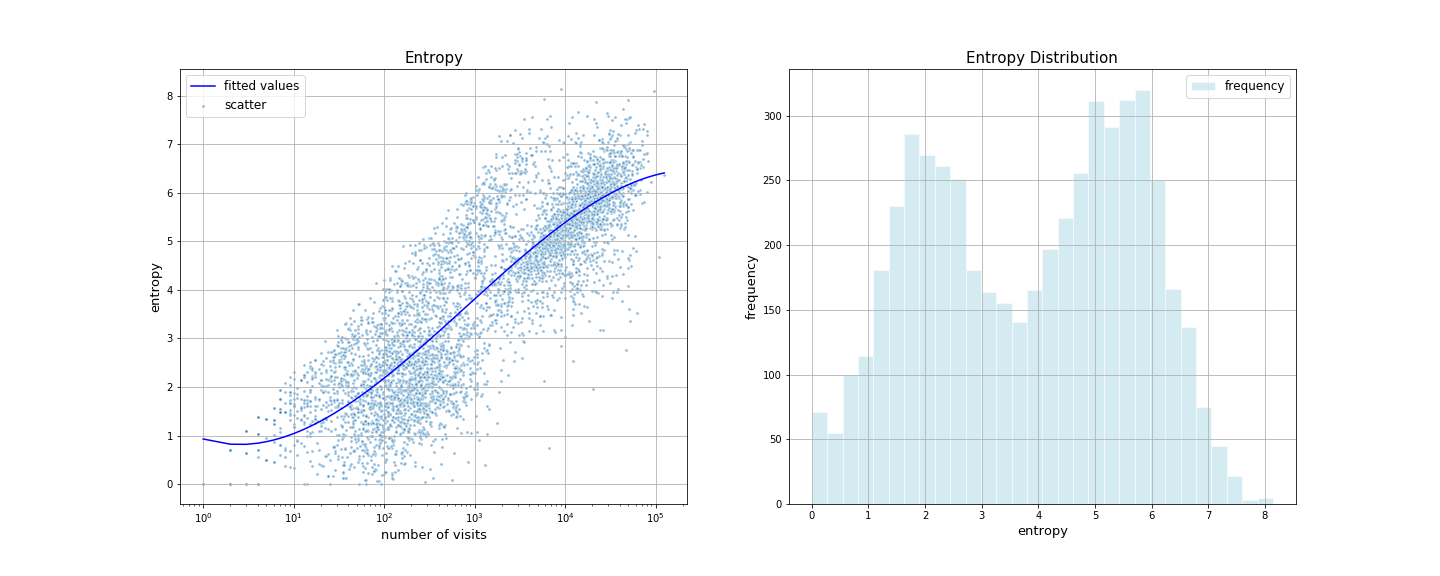

In [3]:
from PIL import Image

im = Image.open("./outcomes/figure/3.1_entropy2.png")
display(im)

### 3.2 基于FastUnfolding的城市社区划分、城市流动性研究
首先定义了共有用户的概念：给定两个基站A和B，定义用户i被基站A记录的次数为 $q_{iA}$ , 被基站B记录的次数为 $q_{iB}$，定义基站A被所有用户的平均访问数为
$$ \mu_A = \frac{1}{|\Phi_A|} \cdot \sum_{j=1}^{n}{q_{jA}} $$  
其中 $\Phi_A$ 为去过地点A的所有用户集合。则如果
$$ q_{iA} > \mu_A \quad and \quad q_{iB} > \mu_B $$  
则称用户i为基站A和基站B的共有用户。若两个基站之间存在共有用户，则认为基站间存在一条边。定义边的权重为两个基站表示向量的 Cosine Similarity。

由于数据中含有7万多名用户，数据量太多。因此我首先对用户进行了筛选，过滤曾去过上海以外地方的用户。然后，按照上述定义，我们得到了64005个共有用户。  
考虑到基站只是记录了短时间内用户的活跃地点，因此如果用户在上海市内过于活跃，则说明该用户的数据并没有太大意义。  
据个例子就可以明白，若用户为一名司机，则司机的职业就是在上海市内不停游走，导致用户的活跃地点数据并不能反映两个地点之间的联系。  
因此，我们过滤了活跃地点>10的用户，得到了42965个种子用户。根据这42965个种子用户，我们构建了一个目标Graph的候选边集合 $\tilde{E}$.  
$\tilde{E}$ 中大约含有上百万条边，如果单纯的利用这上百万条边来构建Graph，则会造成一些噪声。  
我们的边是利用用户得来的，并不是所有用户对地点的访问都是有意义的。所以对得到的边，我又进行了以此过滤。删除掉了两个基站表示向量的 Cosine Similarity过小的边。  
最终我们构建的图 $G=(V, E)$ 含有 327530 条边和 4345 个基站。图的度分布如下：

#### 3.2.1 Fast-Unfolding

Fast-Unfolding 算法：基于模块度的聚类算法。模块度  
$$ 
Q = \frac{1}{2m} \sum_{i,j}{ \left[  A_{i,j}- \frac{k_i k_j}{2m}  \right] \delta(c_i, c_j) }
$$
其中 $A_{i,j}$ 是边 $(i,j)$ 的权重, $k_i$ 是结点 $i$ 的度数, $c_i$ 是结点 $i$ 所属社区的 Index,  $m$ 是整个网络的总度数。

In [ ]:
import networkx as nx
import pandas as pd
from itertools import permutations
from itertools import combinations
from collections import defaultdict
import numpy as np
import unicodecsv as csv


class FastUnfolding(object):
    def __init__(self):
        self.MIN_VALUE = 0.0000001
        self.node_weights = {}    #节点权重

    @classmethod
    def convertIGraphToNxGraph(cls, igraph):
        node_names = igraph.vs["name"]
        edge_list = igraph.get_edgelist()
        weight_list = igraph.es["weight"]
        node_dict = defaultdict(str)

        for idx, node in enumerate(igraph.vs):
            node_dict[node.index] = node_names[idx]

        convert_list = []
        for idx in range(len(edge_list)):
            edge = edge_list[idx]
            new_edge = (node_dict[edge[0]], node_dict[edge[1]], weight_list[idx])
            convert_list.append(new_edge)

        convert_graph = nx.Graph()
        convert_graph.add_weighted_edges_from(convert_list)
        return convert_graph

    def updateNodeWeights(self, edge_weights):
        node_weights = defaultdict(float)
        for node in edge_weights.keys():
            node_weights[node] = sum([weight for weight in edge_weights[node].values()])
        return node_weights

    def getBestPartition(self, graph, param=1.):
        node2com, edge_weights = self._setNode2Com(graph)    #获取节点和边

        node2com = self._runFirstPhase(node2com, edge_weights, param)
        best_modularity = self.computeModularity(node2com, edge_weights, param)

        partition = node2com.copy()
        new_node2com, new_edge_weights = self._runSecondPhase(node2com, edge_weights)

        while True:
            new_node2com = self._runFirstPhase(new_node2com, new_edge_weights, param)
            modularity = self.computeModularity(new_node2com, new_edge_weights, param)
            if abs(best_modularity - modularity) < self.MIN_VALUE:
                break
            best_modularity = modularity
            partition = self._updatePartition(new_node2com, partition)
            _new_node2com, _new_edge_weights = self._runSecondPhase(new_node2com, new_edge_weights)
            new_node2com = _new_node2com
            new_edge_weights = _new_edge_weights

        return partition

    def computeModularity(self, node2com, edge_weights, param):
        q = 0
        all_edge_weights = sum(
            [weight for start in edge_weights.keys() for end, weight in edge_weights[start].items()]) / 2

        com2node = defaultdict(list)
        for node, com_id in node2com.items():
            com2node[com_id].append(node)

        for com_id, nodes in com2node.items():
            node_combinations = list(combinations(nodes, 2)) + [(node, node) for node in nodes]
            cluster_weight = sum([edge_weights[node_pair[0]][node_pair[1]] for node_pair in node_combinations])
            tot = self.getDegreeOfCluster(nodes, node2com, edge_weights)
            q += (cluster_weight / (2 * all_edge_weights)) - param * ((tot / (2 * all_edge_weights)) ** 2)
        return q

    def getDegreeOfCluster(self, nodes, node2com, edge_weights):
        weight = sum([sum(list(edge_weights[n].values())) for n in nodes])
        return weight

    def _updatePartition(self, new_node2com, partition):
        reverse_partition = defaultdict(list)
        for node, com_id in partition.items():
            reverse_partition[com_id].append(node)

        for old_com_id, new_com_id in new_node2com.items():
            for old_com in reverse_partition[old_com_id]:
                partition[old_com] = new_com_id
        return partition

    def _runFirstPhase(self, node2com, edge_weights, param):
        # 计算所有边上的权重之和
        all_edge_weights = sum(
            [weight for start in edge_weights.keys() for end, weight in edge_weights[start].items()]) / 2
        self.node_weights = self.updateNodeWeights(edge_weights) #输出一个字典，每个node对应node上边的权重和
        status = True
        while status:
            statuses = []
            for node in node2com.keys():   # 逐一选择节点和周边连接的节点进行比较
                #statuses = []
                com_id = node2com[node]    # 获取节点对应的社团编号
                neigh_nodes = [edge[0] for edge in self.getNeighborNodes(node, edge_weights)] #获取连接的所有边节点

                max_delta = 0.              # 用于计算比对
                max_com_id = com_id         # 默认当前社团id为最大社团id
                communities = {}
                for neigh_node in neigh_nodes:
                    node2com_copy = node2com.copy()
                    if node2com_copy[neigh_node] in communities:
                        continue
                    communities[node2com_copy[neigh_node]] = 1
                    node2com_copy[node] = node2com_copy[neigh_node] # 把node对应的社团id放到临近的neigh_node中

                    delta_q = 2 * self.getNodeWeightInCluster(node, node2com_copy, edge_weights) - (self.getTotWeight(
                        node, node2com_copy, edge_weights) * self.node_weights[node] / all_edge_weights) * param
                    if delta_q > max_delta:
                        max_delta = delta_q                     # max_delta 选择最大的增益的node
                        max_com_id = node2com_copy[neigh_node]  # 对应 max_com_id 选择最大的增益的临接node的id

                node2com[node] = max_com_id
                statuses.append(com_id != max_com_id)

            print(sum(statuses))

            if sum(statuses) == 0:
                break

        return node2com

    def _runSecondPhase(self, node2com, edge_weights):
        """
        :param node2com:       第一层phase 构建完之后的node->社团结果
        :param edge_weights:   社团边字典
        :return:
        """
        com2node = defaultdict(list)

        new_node2com = {}
        new_edge_weights = defaultdict(lambda: defaultdict(float))

        for node, com_id in node2com.items():
            #生成了社团：--->节点映射
            com2node[com_id].append(node)  #添加同一一个社团id对应的node
            if com_id not in new_node2com:
                new_node2com[com_id] = com_id

        nodes = list(node2com.keys())
        node_pairs = list(permutations(nodes, 2)) + [(node, node) for node in nodes]
        for edge in node_pairs:
            new_edge_weights[new_node2com[node2com[edge[0]]]][new_node2com[node2com[edge[1]]]] += edge_weights[edge[0]][
                edge[1]]
        return new_node2com, new_edge_weights

    def getTotWeight(self, node, node2com, edge_weights):
        """
        :param node:
        :param node2com:
        :param edge_weights:
        :return:
        """
        nodes = [n for n, com_id in node2com.items() if com_id == node2com[node] and node != n]

        weight = 0.
        for n in nodes:
            weight += sum(list(edge_weights[n].values()))
        return weight

    def getNeighborNodes(self, node, edge_weights):
        """
        :param node:  输入节点
        :param edge_weights: 边字典
        :return: 输出每个节点连接点边集合
        """
        if node not in edge_weights:
            return 0
        return edge_weights[node].items()

    def getNodeWeightInCluster(self, node, node2com, edge_weights):
        neigh_nodes = self.getNeighborNodes(node, edge_weights)
        node_com = node2com[node]
        weights = 0.
        for neigh_node in neigh_nodes:
            if node_com == node2com[neigh_node[0]]:
                weights += neigh_node[1]
        return weights

    def _setNode2Com(self,graph):
        """
        :return: 节点->团，edge_weights 形式：{'a': defaultdict(<class 'float'>, {'c': 1.0, 'b': 1.0})}
        """
        node2com = {}
        edge_weights = defaultdict(lambda: defaultdict(float))
        for idx,node in enumerate(graph.nodes()):
            node2com[node] = idx    #给每一个节点初始化赋值一个团id
            for edge in graph[node].items():
                edge_weights[node][edge[0]] = edge[1]['weight']
        return node2com,edge_weights

In [ ]:
    # print("now entering fast-unfolding")
    # client = FastUnfolding()
    # partition = client.getBestPartition(g)

    # print("now deal with index.. ")
    # p = defaultdict(list)
    # classes = set()
    # for node, com_id in partition.items():
    #     p[com_id].append(node)
    #     classes.add(com_id)

In [2]:
import pickle as pkl

with open("./data/p_dict_edges_weight_0.15.pkl", "rb") as f:
    outcomeDict = pkl.load(f)

In [9]:
len(outcomeDict)

9

In [8]:
station_data = pd.read_csv("./data/station.csv", sep='\t', header=0)
colors = [
    (151, 255, 255), # DarkSlateGray1
    (118, 238, 198), # Aquamarine2
    (0, 255, 127), # SpringGreen1
    (132, 112, 255), # LightSlateBlue
    (255, 255, 0), # Yellow1
    (255, 193, 37), # Goldenrod1	
    (255, 193, 193), # RosyBrown1
    (255, 106, 106), # IndianRed1
    (238, 130, 238), # Violet
    (160, 32, 240), # purple
]

mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
                .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=11, is_roam=False,
                            map_style=json.load(open("./mapstyle/green.json", "r")))

for i in range(station_data.shape[0]): # 添加所有基站的坐标
    mapWorker.add_coordinate(name=station_data.iloc[i, 0], 
                            longitude=station_data.iloc[i, 1], 
                            latitude=station_data.iloc[i, 2])

for i, key in enumerate(outcomeDict.keys()):
    r, g, b = colors[i]
    data_pair = [(st, key) for st in outcomeDict[key]]
    mapWorker = mapWorker.add(
        series_name=str(key), 
        data_pair=data_pair,
        type_=GeoType.EFFECT_SCATTER,
        # symbol_size=4,
        # blur_size=0,
        # point_size=1,
        label_opts=opts.LabelOpts(is_show=False),
        effect_opts=opts.EffectOpts(is_show=True),
        itemstyle_opts=opts.ItemStyleOpts(color='rgba({}, {}, {}, {})'.format(r, g, b, 0.5)),
    )
    
c = mapWorker.add_control_panel(
        navigation_control_opts=opts.BMapNavigationControlOpts(),
        overview_map_opts=opts.BMapOverviewMapControlOpts(),
        scale_control_opts=opts.BMapScaleControlOpts(),
    ) \
    .set_global_opts(
        title_opts=opts.TitleOpts(title="{}".format("fastunfolding"), pos_left='right'), visualmap_opts=None,
    ) \
    .render("{}/3.2_fastunfolding_visual.html".format("./outcomes/web"))
    
print("{}/3.2_fastunfolding_visual.html".format("./outcomes/web"))

./outcomes/web/3.2_fastunfolding_visual.html


#### 3.2.2 GMM clustering by POI

In [11]:
station_data = pd.read_csv("./data/station_POI_total.csv", sep=',', header=0)
station_vec = np.array(station_data.iloc[:, 3:]).astype(np.float64)

In [14]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM

n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=2020).fit(station_vec)
          for n in n_components]

Text(0.5, 0, 'n_components')

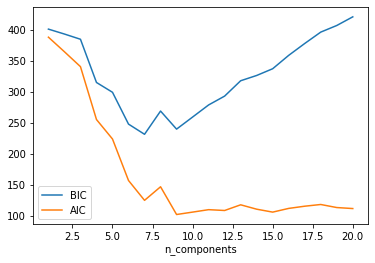

In [30]:
# plt.plot(n_components, [m.bic(station_vec) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(station_vec) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components')

In [24]:
labels = models[6].predict(station_vec)

In [25]:
from collections import defaultdict
label_dict = defaultdict(list)

for i, lab in enumerate(labels):
    label_dict[lab].append(station_data.iloc[i, 0])

In [26]:
colors = [
    (151, 255, 255), # DarkSlateGray1
    (118, 238, 198), # Aquamarine2
    (0, 255, 127), # SpringGreen1
    (132, 112, 255), # LightSlateBlue
    (255, 255, 0), # Yellow1
    (255, 193, 37), # Goldenrod1	
    (255, 193, 193), # RosyBrown1
    (255, 106, 106), # IndianRed1
    (238, 130, 238), # Violet
    (160, 32, 240), # purple
    (60, 179, 113), # MediumSeaGreen
    (139, 58, 58), # IndianRed4
    (255, 140, 0), # Dark Orange
    (202, 255, 112), # DarkOliveGreen1
]

mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
                .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=11, is_roam=False,
                            map_style=json.load(open("./mapstyle/green.json", "r")))

for i in range(station_data.shape[0]): # 添加所有基站的坐标
    mapWorker.add_coordinate(name=station_data.iloc[i, 0], 
                            longitude=station_data.iloc[i, 1], 
                            latitude=station_data.iloc[i, 2])

for i, key in enumerate(label_dict.keys()):
    r, g, b = colors[i]
    data_pair = [(st, key) for st in label_dict[key]]
    mapWorker = mapWorker.add(
        series_name=str(key), 
        data_pair=data_pair,
        type_=GeoType.EFFECT_SCATTER,
        # symbol_size=4,
        # blur_size=0,
        # point_size=1,
        label_opts=opts.LabelOpts(is_show=False),
        effect_opts=opts.EffectOpts(is_show=True),
        itemstyle_opts=opts.ItemStyleOpts(color='rgba({}, {}, {}, {})'.format(r, g, b, 0.5)),
    )
    
c = mapWorker.add_control_panel(
        navigation_control_opts=opts.BMapNavigationControlOpts(),
        overview_map_opts=opts.BMapOverviewMapControlOpts(),
        scale_control_opts=opts.BMapScaleControlOpts(),
    ) \
    .set_global_opts(
        title_opts=opts.TitleOpts(title="{}".format("gmm_poi_clustering"), pos_left='right'), visualmap_opts=None,
    ) \
    .render("{}/3.2.2_gmm_poi_clustering.html".format("./outcomes/web"))
    
print("{}/3.2.2_gmm_poi_clustering.html".format("./outcomes/web"))

./outcomes/web/3.2.2_gmm_poi_clustering.html


#### 3.2.3 Population Flow

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_correlation(npArray, figname, xticklabels, yticklabels, path="./outcomes/figure"):
    plt.subplots(figsize=(16, 15)) # 设置画面大小
    sns.heatmap(npArray, annot=True, xticklabels=xticklabels, yticklabels=yticklabels, square=True) # cmap="Blues"
    plt.savefig('{}/3.2.3_{}.png'.format(path, figname))

    print("Saved at [{}/3.2.3_{}.png]".format(path, figname))

In [3]:
data = pd.read_csv("./data/corr_matrix.csv", sep=',', header=0, index_col=0)

In [4]:
xy = ['Huang Pu',
 'Xu Hui',
 'Chang Ning',
 'Jing An',
 'Pu Tuo',
 'Hong Kou',
 'Yang Pu',
 'Pu Dong',
 'Min Hang',
 'Bao Shan',
 'Jia Ding',
 'Jin Shang',
 'Song Jiang',
 'Qing Pu',
 'Feng Xian',
 'Chong Ming']

Saved at [./outcomes/figure/3.2.3_population_flow_corr.png]


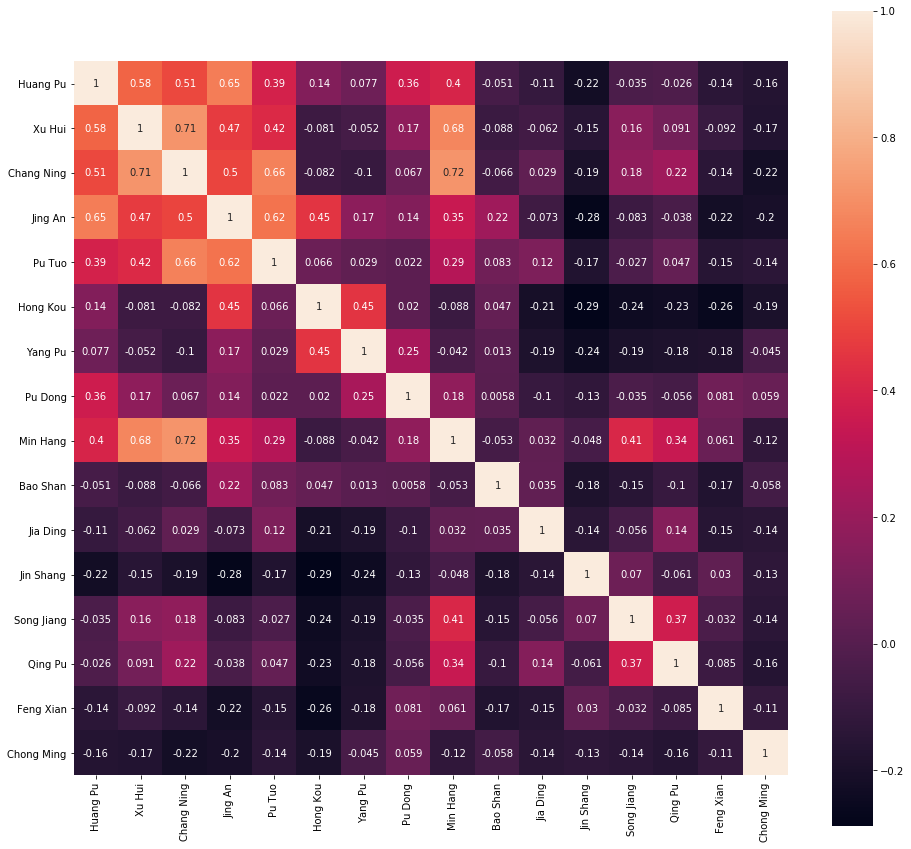

In [10]:
draw_correlation(data.corr(), figname="population_flow_corr", xticklabels=xy, yticklabels=xy)

Saved at [./outcomes/figure/3.2.3_population_flow.png]


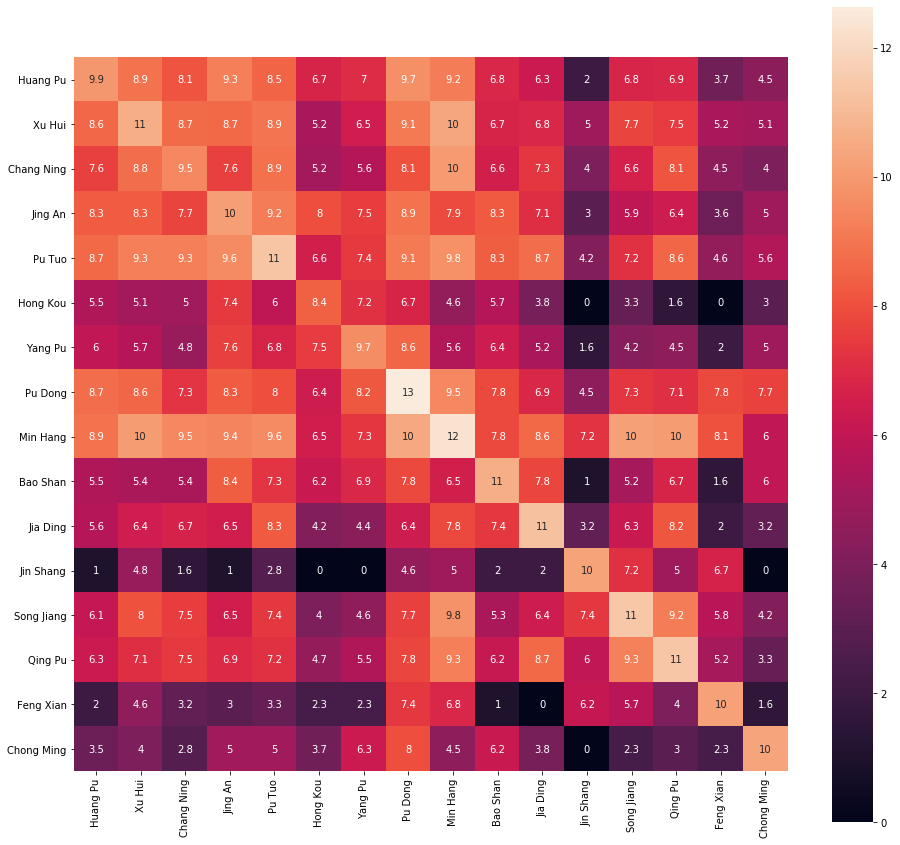

In [11]:
draw_correlation(np.log2(data), figname="population_flow", xticklabels=xy, yticklabels=xy)

#### 3.2.4 区域基础设施研究
pyecharts Bar3D Figure

In [43]:
data = pd.read_csv("./data/district_infrastructure.csv", sep=',', header=0)

In [16]:
data

,district,美食,酒店,生活服务,景点,休闲,教育,医疗,交通,金融,房地产,公司企业,政府机构
0,宝山区,7421,798,6789,939,10823,2919,1206,8574,1240,3937,16680,3916
1,普陀区,19510,3090,16459,2880,29107,10383,4559,26642,6935,5137,39744,17654
2,嘉定区,6926,756,5497,906,9002,1564,985,9915,939,3465,15782,3068
3,静安区,38991,8685,24613,8040,51639,15788,12244,49606,19712,7357,60008,39641
4,虹口区,15094,2357,10896,2290,18679,6105,3585,20851,5753,2526,25849,14079
5,浦东新区,37852,6769,29667,6858,49905,13351,8365,57133,18080,17802,74942,25079
6,杨浦区,13230,1955,9604,1607,16921,9380,3407,17842,3362,2542,24027,11542
7,长宁区,25341,5865,16443,4233,33263,10835,7311,30822,9737,5618,39347,23181
8,徐汇区,33800,7906,21749,5449,43971,18635,11195,41679,13265,5765,54501,30177
9,黄浦区,35365,13796,19953,11258,45691,14841,11873,46045,21277,7566,50069,37340


In [63]:
districts = data['district'].tolist()

len(districts)

16

In [17]:
cols = ['生活服务', '教育', '医疗', '交通', '政府机构']

In [56]:
barData = []
maxv = 0
for i in range(16):
    for j, c in enumerate(cols):
        d = data.iloc[i, 0]
        v = int(data.loc[i, c])
        if v>maxv: maxv = v
        barData.append([i, j, v])

In [45]:
len(barData)

80

In [49]:
maxv

57133

In [68]:
xlabels = ['宝山', '普陀', '嘉定', '静安', '虹口', '浦东', '杨浦', '长宁', '徐汇', '黄浦', '崇明', '闵行', '松江', '青浦', '金山', '奉贤']

In [75]:
from pyecharts.charts import Bar3D

c = (
    Bar3D(init_opts=opts.InitOpts(width="1300px", height="650px"))
    .add(
        series_name="",
        data=barData, # [(x, y, val)]
        xaxis3d_opts=opts.Axis3DOpts(type_="category", data=xlabels, interval=0),
        yaxis3d_opts=opts.Axis3DOpts(type_="category", data=cols),
        zaxis3d_opts=opts.Axis3DOpts(type_="value"),
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            max_=60000,
            range_color=[
                "#313695",
                "#4575b4",
                "#74add1",
                "#abd9e9",
                "#e0f3f8",
                "#ffffbf",
                "#fee090",
                "#fdae61",
                "#f46d43",
                "#d73027",
                "#a50026",
            ],
        )
    )
    .render("{}/3.2.4_{}.html".format("./outcomes/web", "Regional_Infrastructure"))
)
print("Saved at " + "{}/3.2.4_{}.html".format("./outcomes/web", "Regional_Infrastructure"))

Saved at ./outcomes/web/3.2.4_Regional_Infrastructure.html


#### 3.2.5 POI与经济

In [55]:
data = pd.read_csv("./data/corr_matrix.csv", sep=',', header=0)

In [16]:
df1 = pd.read_csv("./data/district_infrastructure.csv", header=0)
df2 = pd.read_csv("./data/districtsINFO.csv", header=0)

In [57]:
districtDF = pd.merge(left=df1, right=df2, how="inner", on="district")

districtDF = pd.merge(left=districtDF, right=data, how="inner", on="district")

districtDF

,district,美食,酒店,生活服务,景点,休闲,教育,医疗,交通,金融,...,杨浦区,浦东新区,闵行区,宝山区,嘉定区,金山区,松江区,青浦区,奉贤区,崇明区
0,宝山区,7421,798,6789,939,10823,2919,1206,8574,1240,...,118,227,92,1604,219,2,37,107,3,64
1,普陀区,19510,3090,16459,2880,29107,10383,4559,26642,6935,...,172,543,873,325,429,18,146,377,25,47
2,嘉定区,6926,756,5497,906,9002,1564,985,9915,939,...,21,84,224,168,2387,9,77,285,4,9
3,静安区,38991,8685,24613,8040,51639,15788,12244,49606,19712,...,184,477,232,307,137,8,61,84,12,32
4,虹口区,15094,2357,10896,2290,18679,6105,3585,20851,5753,...,143,107,25,51,14,1,10,3,1,8
5,浦东新区,37852,6769,29667,6858,49905,13351,8365,57133,18080,...,301,6377,716,223,119,23,161,141,229,203
6,杨浦区,13230,1955,9604,1607,16921,9380,3407,17842,3362,...,807,376,47,84,38,3,19,23,4,31
7,长宁区,25341,5865,16443,4233,33263,10835,7311,30822,9737,...,50,271,1059,94,162,16,100,280,23,16
8,徐汇区,33800,7906,21749,5449,43971,18635,11195,41679,13265,...,88,554,1352,106,114,31,209,179,38,34
9,黄浦区,35365,13796,19953,11258,45691,14841,11873,46045,21277,...,131,827,594,113,79,4,111,116,13,22


In [85]:
X = np.array(districtDF[
    ["美食","酒店","生活服务","景点","休闲","教育","医疗","交通","金融","房地产","公司企业","政府机构", "人口", "面积"]])
# "美食","酒店","生活服务","景点","休闲", "基站数", "用户数", 
# "黄浦区","徐汇区","长宁区","静安区","普陀区","虹口区","杨浦区","浦东新区",
#      "闵行区","宝山区","嘉定区","金山区","松江区","青浦区","奉贤区","崇明区"]

Y = np.array(districtDF["GDP"])

[Text(152.62941176470588, 203.85, 'X[5] <= 67475.0\nmse = 4489194.793\nsamples = 16\nvalue = 1782.822'),
 Text(132.93529411764706, 176.67000000000002, 'X[2] <= 9244.5\nmse = 385675.624\nsamples = 15\nvalue = 1258.251'),
 Text(78.7764705882353, 149.49, 'X[1] <= 1054.5\nmse = 132016.312\nsamples = 6\nvalue = 728.009'),
 Text(59.082352941176474, 122.31, 'X[2] <= 2194.5\nmse = 77504.371\nsamples = 5\nvalue = 844.138'),
 Text(39.38823529411765, 95.13, 'mse = 0.0\nsamples = 1\nvalue = 332.84'),
 Text(78.7764705882353, 95.13, 'X[8] <= 681.5\nmse = 15184.95\nsamples = 4\nvalue = 971.962'),
 Text(59.082352941176474, 67.94999999999999, 'X[1] <= 703.0\nmse = 3754.475\nsamples = 3\nvalue = 1036.173'),
 Text(39.38823529411765, 40.77000000000001, 'X[6] <= 1636.0\nmse = 238.857\nsamples = 2\nvalue = 993.775'),
 Text(19.694117647058825, 13.590000000000003, 'mse = 0.0\nsamples = 1\nvalue = 978.32'),
 Text(59.082352941176474, 13.590000000000003, 'mse = -0.0\nsamples = 1\nvalue = 1009.23'),
 Text(78.7764

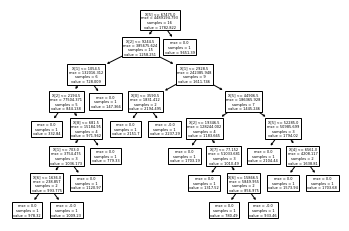

In [86]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
decision_tree = clf.fit(X,Y)
tree.plot_tree(decision_tree) 

In [87]:
dt_fi = decision_tree.feature_importances_
print(dt_fi)

[5.09950033e-05 1.79404520e-02 4.87033330e-02 0.00000000e+00
 1.17173488e-04 9.30361048e-01 1.69540768e-04 1.96863160e-03
 6.88825832e-04]


In [88]:
import matplotlib.pyplot as plt

names = np.array(
    ["Food","Hotel","Service","Scenery", "Entertainment","Education","Medical Care","Traffic","Finance","Real Estate",
     "Company", "Government", "Population", "Area",
     ]
)
# "Food","Hotel","Service","Scenery", "Entertainment", "#Stations", "#Users",
# "Huang Pu", "Xu Hui", "Chang Ning", "Jing An", "Pu Tuo", "Hong Kou", "Yang Pu", "Pu Dong",
#  "Min Hang", "Bao Shan", "Jia Ding", "Jin Shan", "Song Jiang", "Qing Pu", "Feng Xian", "Chong Ming"
sorted_indexes = dt_fi.argsort()[::-1]  # 下标排序,从大到小
x = np.arange(names.size)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


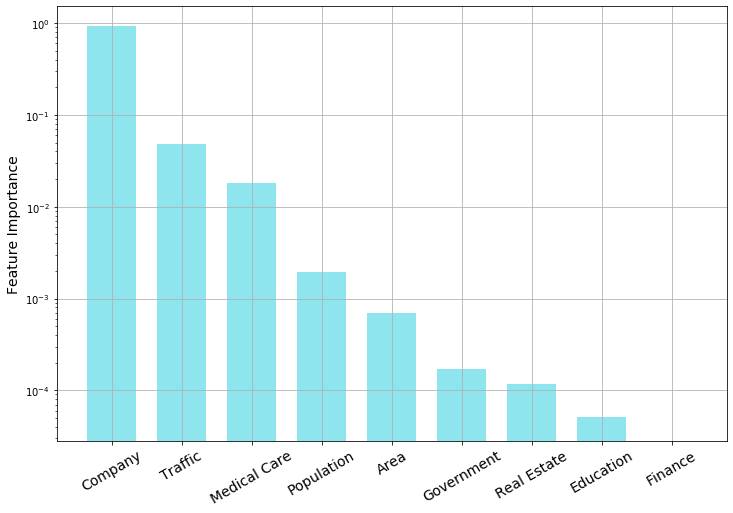

In [92]:
plt.figure('Feature Importance', figsize=(12, 8))

plt.ylabel('Feature Importance', fontsize=14)
plt.yscale("log")
plt.grid()

plt.bar(x, dt_fi[sorted_indexes], 0.7, color='#8EE5EE')
plt.xticks(x, names[sorted_indexes], rotation=30, fontsize=14)  # 设置x轴坐标

plt.show()

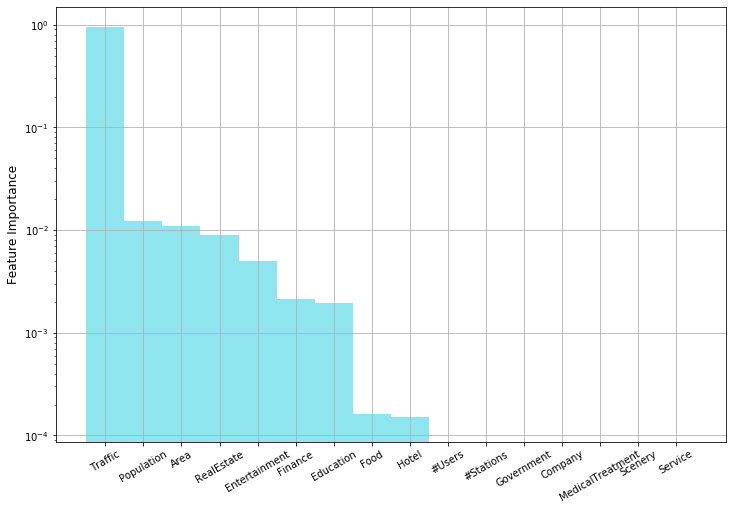

In [45]:
import matplotlib.pyplot as plt

names = np.array(["Food","Hotel","Service", "Scenery","Entertainment","Education","MedicalTreatment","Traffic", "Finance","RealEstate","Company", "Government", "#Stations", "#Users", "Population", "Area"])
sorted_indexes = dt_fi.argsort()[::-1]

plt.figure('Feature Importance', figsize=(12, 8))
plt.ylabel('Feature Importance', fontsize=12)
plt.grid()
plt.yscale("log")

x = np.arange(names.size)
plt.bar(x, dt_fi[sorted_indexes], 1, color='#8EE5EE')
plt.xticks(x, names[sorted_indexes], rotation=30, fontsize=10)  # 设置x轴坐标

plt.show()

### 3.3 城市功能区划分

In [98]:
station_data

,station_id,lng,lat,美食,酒店,生活服务$汽车服务,旅游景点$自然地物,休闲娱乐$购物$运动健身$文化传媒,教育培训,医疗,交通设施,金融,房地产,公司企业,政府机构
0,C0001,121.3992,31.3393,0,0,4,0,5,5,1,5,0,4,30,5
1,C0002,121.3782,31.3233,22,0,15,1,38,6,3,24,2,6,33,9
2,C0003,121.4052,31.3263,3,0,2,4,9,39,0,18,0,3,9,5
3,C0004,121.3942,31.3083,1,0,6,0,5,0,3,7,0,30,25,2
4,C0005,121.4212,31.3053,48,5,15,3,44,3,4,56,5,6,75,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,C9392,121.6681,31.1416,9,2,13,11,8,0,0,14,5,0,2,2
6156,C9395,121.6571,31.1476,1,3,1,2,4,0,0,16,0,2,2,0
6157,C9397,121.6621,31.1456,15,1,23,20,9,0,1,23,3,1,5,2
6158,C9937,121.0726,30.8887,0,0,0,0,0,0,0,3,0,0,0,0


In [94]:
import pickle as pkl

with open("./data/p_dict_edges_weight_0.15.pkl", "rb") as f:
    outcomeDict = pkl.load(f)

In [112]:
catrgories = [2905, 329, 1789, 1448, 899, 288, 2636, 2750, 4330]
inverse_dict = {}
nitems = []
for key, val in outcomeDict.items():
    nitems += list(val)
    for v in val:
        inverse_dict[v] = catrgories.index(key)

nitems = sorted(list(set(nitems)))

In [113]:
matrix = np.zeros((len(nitems),len(catrgories)))

for i in range(len(nitems)):
    j = inverse_dict[nitems[i]]
    matrix[i, j] = 1

In [121]:
matrixDict = dict([(str(i), matrix[:, i]) for i in range(len(catrgories))])
matrixDict["station_id"] = nitems

In [122]:
matrixDF = pd.DataFrame(matrixDict)

In [124]:
dataDF = pd.merge(left=station_data, right=matrixDF, how="inner", on="station_id")

In [125]:
dataDF

,station_id,lng,lat,美食,酒店,生活服务$汽车服务,旅游景点$自然地物,休闲娱乐$购物$运动健身$文化传媒,教育培训,医疗,...,政府机构,0,1,2,3,4,5,6,7,8
0,C0001,121.3992,31.3393,0,0,4,0,5,5,1,...,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C0003,121.4052,31.3263,3,0,2,4,9,39,0,...,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C0004,121.3942,31.3083,1,0,6,0,5,0,3,...,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,C0005,121.4212,31.3053,48,5,15,3,44,3,4,...,24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C0006,121.4012,31.2993,6,0,7,0,11,4,1,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4340,C9391,121.6681,31.1416,9,2,13,11,8,0,0,...,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4341,C9395,121.6571,31.1476,1,3,1,2,4,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4342,C9397,121.6621,31.1456,15,1,23,20,9,0,1,...,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4343,C9937,121.0726,30.8887,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [126]:
station_vec = np.array(dataDF.iloc[:, 3:]).astype(np.float64)

In [93]:
station_data = pd.read_csv("./data/station_POI_total.csv", sep=',', header=0)

In [128]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM

n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=2020).fit(station_vec)
          for n in n_components]

In [150]:
labels = models[6].predict(station_vec)

In [151]:
from collections import defaultdict
label_dict = defaultdict(list)

for i, lab in enumerate(labels):
    label_dict[lab].append(dataDF.iloc[i, 0])

In [155]:
colors = [
    (151, 255, 255), # DarkSlateGray1
    (118, 238, 198), # Aquamarine2
    (0, 255, 127), # SpringGreen1
    (132, 112, 255), # LightSlateBlue
    (255, 255, 0), # Yellow1
    (255, 193, 37), # Goldenrod1	
    # (255, 193, 193), # RosyBrown1
    (255, 106, 106), # IndianRed1
    (238, 130, 238), # Violet
    (160, 32, 240), # purple
    (60, 179, 113), # MediumSeaGreen
    (139, 58, 58), # IndianRed4
    (255, 140, 0), # Dark Orange
    (202, 255, 112), # DarkOliveGreen1
    (72, 209, 204), # MediumTurquoise
    (255, 130, 71), # Sienna1
]

mapWorker = BMap(init_opts= opts.InitOpts(width="1200px", height="750px")) \
                .add_schema(baidu_ak=chromeKey, center=[121.46, 31.23], zoom=11, is_roam=False,
                            map_style=json.load(open("./mapstyle/green.json", "r")))

for i in range(station_data.shape[0]): # 添加所有基站的坐标
    mapWorker.add_coordinate(name=station_data.iloc[i, 0], 
                            longitude=station_data.iloc[i, 1], 
                            latitude=station_data.iloc[i, 2])

for i, key in enumerate(label_dict.keys()):
    r, g, b = colors[i]
    data_pair = [(st, key) for st in label_dict[key]]
    mapWorker = mapWorker.add(
        series_name=str(key), 
        data_pair=data_pair,
        # type_=GeoType.EFFECT_SCATTER,
        symbol_size=10,
        blur_size=4,
        point_size=10,
        label_opts=opts.LabelOpts(is_show=False),
        effect_opts=opts.EffectOpts(is_show=True),
        itemstyle_opts=opts.ItemStyleOpts(color='rgba({}, {}, {}, {})'.format(r, g, b, 0.7)),
    )
    
c = mapWorker.add_control_panel(
        navigation_control_opts=opts.BMapNavigationControlOpts(),
        overview_map_opts=opts.BMapOverviewMapControlOpts(),
        scale_control_opts=opts.BMapScaleControlOpts(),
    ) \
    .set_global_opts(
        title_opts=opts.TitleOpts(title="{}".format("urban_functional_area_division"), pos_left='right'), visualmap_opts=None,
    ) \
    .render("{}/3.4_urban_functional_area_division.html".format("./outcomes/web"))
    
print("{}/3.4_urban_functional_area_division.html".format("./outcomes/web"))

./outcomes/web/3.4_urban_functional_area_division.html


Text(0.5, 0, 'n_components')

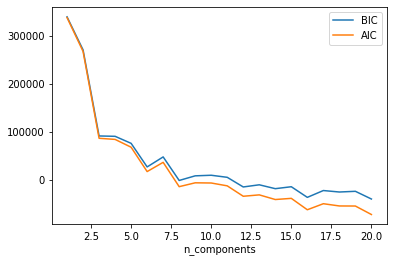

In [129]:
plt.plot(n_components, [m.bic(station_vec) for m in models], label='BIC')
plt.plot(n_components, [m.aic(station_vec) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')